<a id="top"></a>
# **Bank Subscription Binary Classification: XGBoost**

### By Conrad Kleykamp

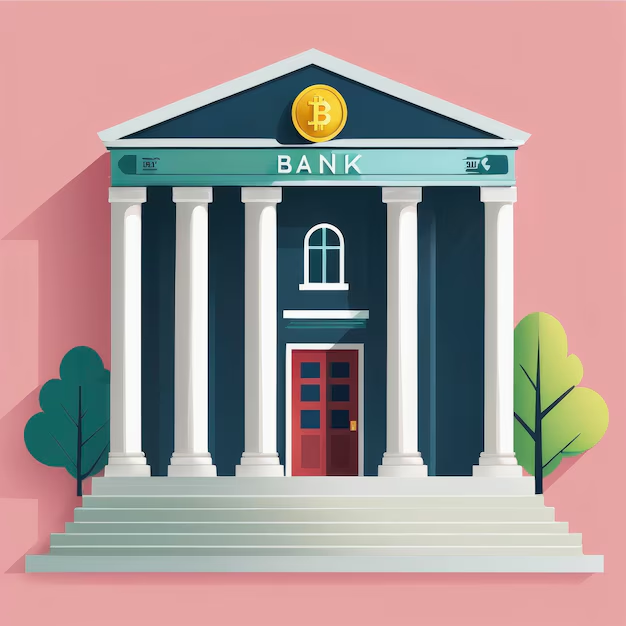

Table of Contents:
- [About the Project](#1)
- [About the Data](#2)
- [Set Up](#3)
- [Data Overview](#4)
    - [Training Data](#4.1)
    - [Testing Data](#4.2)
    - [Target Variable: y](#4.3) 
- [Baseline XGBoost](#5)
- [Data Preprocessing](#6)
    - [Changing Datatypes](#6.1)
    - [Outlier Removal](#6.2)
    - [Feature Engineering](#6.3)
    - [Preparing for Modeling](#6.4)
- [XGBoost w/ Optuna](#7)
    - [Hyperparameter Tuning](#7.1)
    - [Model Evaluation](#7.2) 
- [Submission](#8)
- [Conclusion](#c)
- [References](#r)  
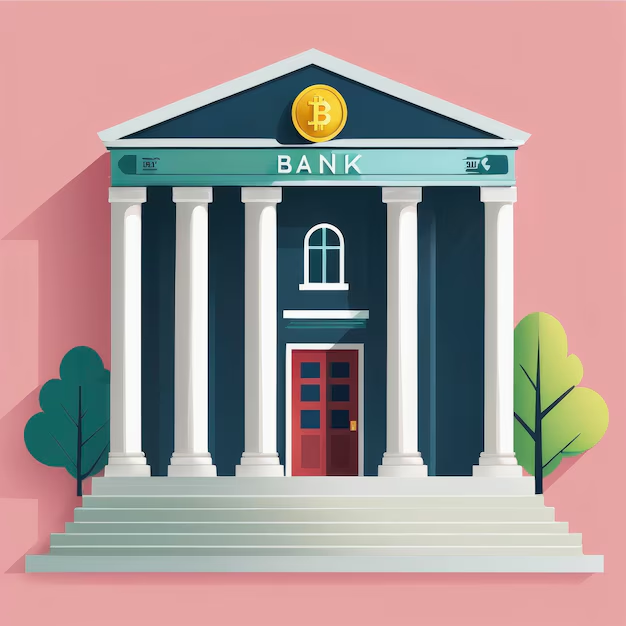

<a id="top"></a>

<a href="#2" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="1"></a>
# **1) About the Project**

---

This project has been completed as part of [Kaggle's Playground Series Competition](https://www.kaggle.com/competitions/playground-series-s5e8/overview) and as part of my continued practice and learning of data science techniques. 

The goal of this competition and project is to predict whether or not a client will subscribe to a bank term deposit. A [term deposit](https://www.investopedia.com/terms/t/termdeposit.asp) is a fixed-interest savings tool where money is deposited into an account at a financial institution and can only be withdrawn after a pre-determined term ends. 

This represents a binary classification task. More specifically, a client either WILL or WONT subscribe to the term deposit. 

In order to solve this task, I will be using [XGBoost](https://xgboost.ai/) (eXtreme Gradient Boosting). XGBoost is a regularizing gradient boosting framework that utilizes decision trees and ensemble learning. This particular type of model is typically very effective in classification tasks.

I will first build and fit a basic XGBoost model to the raw data. This will provide a baseline performance. Following this, I will preprocess the data by removing outliers and creating new features via feature engineering. 

The parameters of a second XGBoost model will be tuned with [Optuna](https://optuna.org/), which is an open source hyperparameter optimization framework. 

All models will be evaluated using the area under the curve (AUC) of the receiver operating characteristic curve (ROC curve). The [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is essentially the plot of the true positive rate versus the false positive rate. In the case of this model and competition, a 'perfect' model would yield an AUC of 1.0, while a terrible model would likely result in an AUC of 0.5 (basically random guess). However, obtaining an AUC of exactly 1 is typically impossible, so the objective will be to get the AUC as close to 1.0 as possible.

In order to speed up this notebook, I will also use NVIDIA's [RAPIDS](https://rapids.ai/cudf-pandas/). By loading in 'cudf.pandas', all pandas operations will be accelerated on the GPU.

If you learned something new from this project or have suggestions on how to improve my model, please let me know! I'm also open to constructive criticism and learning new approaches. 

If you're interested in more of my work, please check out my [profile](https://www.kaggle.com/conradkleykamp)! 

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#3" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="2"></a>
# **2) About the Data**

---

This project utilizes the two datasets provided by Kaggle for this competition. The data is split into a 'train' and a 'test' set. The 'train' set includes 75% of the total data, or 750000 rows/entries. The 'test' set includes 25% of the total data, or 250000 rows/entries. 

**Target Variable**:
- y: 0/1 --> Whether or not the client will subscribe to the term deposit

**Numeric Features**:
- id
- age
- balance
- day
- duration
- campaign
- pdays
- previous

**Categorical Features**
- job
- marital
- education
- default
- housing
- loan
- contact
- month
- poutcome

This data is publicly available for use under the Apache 2.0 license. 

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#4" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="3"></a>
# **3) Set Up**

---

In [1]:
# Checking CUDA version and NVIDIA driver pairs (for CUDF/RAPIDS)
!nvidia-smi

Mon Aug 25 13:36:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Loading in necessary libraries & packages

# Cell magic command to use RAPIDS cuDF for all Pandas
%load_ext cudf.pandas

# Fundamental libraries
import pandas as pd
import numpy as np

# Tracking time
from time import time

# Hiding warnings
import warnings
warnings.filterwarnings("ignore")

# Data viz
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style = 'white', palette = 'Set2')
pal = sns.color_palette('Set2')

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

# CatBoost (for Adversarial Validation)
import catboost
from catboost import Pool, CatBoostClassifier
from catboost.utils import eval_metric

# XGBoost
import xgboost as xgb
xgb.set_config(verbosity=1)
xgb_device = "cuda"

# Optuna
import optuna
from optuna.samplers import TPESampler

# Shap
import shap
shap.initjs()

In [3]:
# Loading in the Kaggle datasets
df_train = pd.read_csv("/kaggle/input/playground-series-s5e8/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s5e8/test.csv")

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#5" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="4"></a>
# **4) Data Overview**

---

<a id="top"></a>
<a id="4.1"></a>
## **4.1) Training Data**

In [4]:
# Viewing first 5 entries of 'df_train'
df_train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [5]:
# Viewing summary info of 'df_train'
df_train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   id         750000 non-null  int64
 1   age        750000 non-null  int64
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64
 13  campaign   750000 non-null  int64
 14  pdays      750000 non-null  int64
 15  previous   750000 non-null  int64
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64
dtypes: int64(9), object(9)
memory usage: 112.4+ MB


In [6]:
# Examining summary statistics of each numeric column in 'df_train'
df_train.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


### **Observations: 'df_train'**

**Shape of the Data**
- 750000 rows, 17 columns (18 including 'id' column)
- 9 numeric columns (int64)
    - id
    - age
    - balance
    - day
    - duration
    - campaign
    - pdays
    - previous
    - **y** (target varaiable) 
- 9 categorical columns (object)
    - job
    - marital
    - education
    - default
    - housing
    - loan
    - contact
    - month
    - poutcome

**Nulls/Missing Values**
- None!

**Numeric Column Statistics** (Rounded up to 2 decimal points)
- **age**
    - Mean: **40.93**; Max: **95**; Min: **18**
- **balance**
    - Mean: **1204.07**; Max: **99717**; Min: **-8019**
- **day**
    - Mean: **16.12**; Max: **31**; Min: **1**
- **duration**
    - Mean: **256.23**; Max: **4918**; Min: **1**
- **campaign**
    - Mean: **2.58**; Max: **63**; Min: **1**
- **pdays**
    - Mean: **22.41**; Max: **871**; Min: **-1**
- **previous**
    - Mean: **0.30**; Max: **200**; Min: **0**
- **y**
    - Mean: **0.12**; Max: **1**; Min: **0**

<a id="top"></a>
<a id="4.2"></a>
## **4.2) Testing Data**

In [7]:
# Viewing first 5 entries of 'df_test'
df_test.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


In [8]:
# Viewing summary info of 'df_test'
df_test.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   id         250000 non-null  int64
 1   age        250000 non-null  int64
 2   job        250000 non-null  object
 3   marital    250000 non-null  object
 4   education  250000 non-null  object
 5   default    250000 non-null  object
 6   balance    250000 non-null  int64
 7   housing    250000 non-null  object
 8   loan       250000 non-null  object
 9   contact    250000 non-null  object
 10  day        250000 non-null  int64
 11  month      250000 non-null  object
 12  duration   250000 non-null  int64
 13  campaign   250000 non-null  int64
 14  pdays      250000 non-null  int64
 15  previous   250000 non-null  int64
 16  poutcome   250000 non-null  object
dtypes: int64(8), object(9)
memory usage: 35.6+ MB


In [9]:
# Examining summary statistics of each numeric column in 'df_test'
df_test.describe()

,id,age,balance,day,duration,campaign,pdays,previous
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,874999.500000,40.932332,1197.426352,16.116068,255.342260,2.573548,22.280028,0.303728
std,72168.927986,10.081613,2741.520699,8.258509,271.404326,2.709661,76.915879,1.384574
min,750000.000000,18.000000,-8019.000000,1.000000,3.000000,1.000000,-1.000000,0.000000
25%,812499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000
50%,874999.500000,39.000000,631.000000,17.000000,133.000000,2.000000,-1.000000,0.000000
75%,937499.250000,48.000000,1389.000000,21.000000,353.000000,3.000000,-1.000000,0.000000
max,999999.000000,95.000000,98517.000000,31.000000,4918.000000,58.000000,871.000000,150.000000


### **Observations: 'df_test'**

**Shape of the Data**
- 250000 rows, 16 columns (17 including 'id' column)
- Columns are identical to 'df_train' with the exclusion of the target variable 'y'

**Nulls/Missing Values**
- None!

**Numeric Column Statistics** (Rounded up to 2 decimal points)
- **age**
    - Mean: **40.93**; Max: **95**; Min: **18**
- **balance**
    - Mean: **1197.43**; Max: **98517**; Min: **-8019**
- **day**
    - Mean: **16.12**; Max: **31**; Min: **1**
- **duration**
    - Mean: **255.34**; Max: **4918**; Min: **3**
- **campaign**
    - Mean: **2.57**; Max: **58**; Min: **1**
- **pdays**
    - Mean: **22.28**; Max: **871**; Min: **-1**
- **previous**
    - Mean: **0.30**; Max: **150**; Min: **0**


<a id="top"></a>
<a id="4.3"></a>
## **4.3) Target Variable: y**

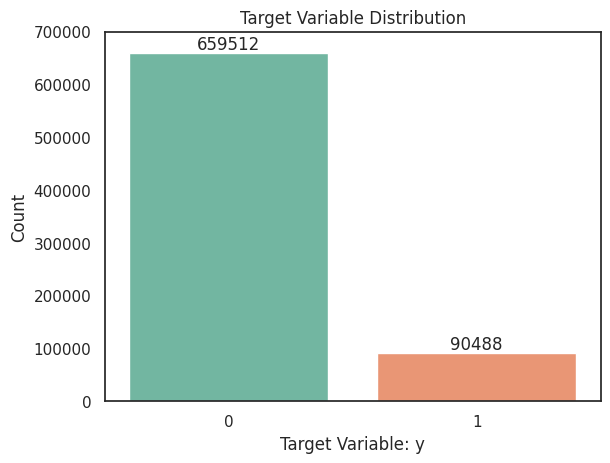

In [10]:
# Creating countplot for target variable 'Personality'
ax = sns.countplot(x='y', data=df_train, palette='Set2')
for label in ax.containers:
  ax.bar_label(label)
ax.set_ylabel('Count')
ax.set_xlabel('Target Variable: y')
ax.set_title('Target Variable Distribution')
ax.set_ylim(0, 700000)
plt.show()

In [11]:
# Checking the % proportion of each target class
print(df_train['y'].value_counts(normalize=True))

y
0    0.879349
1    0.120651
Name: proportion, dtype: float64


### **Observations: Target Variable 'y'**

- Class 0: 659,512 (88%)
- Class 1: 90,488 (12%)

From the countplot above, we can see that there is an imbalance of the two classes. The majority (88%) of the training data is made up of Class 0, with the minority (12%) being Class 1.

This is a common issue in machine learning and can have a profound negative impact on binary classification models. A model trained on imbalanced data may tend to favor the majority class.

In the case of this particular project, a resulting model may yield misleadingly high accuracy scores when predicting Class 0, but may perform worse when predicting Class 1.

Sampling techniques, such as stratified sampling, and model hyperparameter optimization can help reduce the effects of this class imbalance.

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#6" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="5"></a>
# **5) Baseline XGBoost**

---

In [12]:
# Declaring 'object' type columns to be converted to 'category' datatype
objs = df_train.select_dtypes(exclude=np.number).columns.tolist()

# Converting to 'category'
for col in objs:
    df_train[col] = df_train[col].astype('category')

In [13]:
# Verifying changes to datatypes
df_train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   id         750000 non-null  int64
 1   age        750000 non-null  int64
 2   job        750000 non-null  category
 3   marital    750000 non-null  category
 4   education  750000 non-null  category
 5   default    750000 non-null  category
 6   balance    750000 non-null  int64
 7   housing    750000 non-null  category
 8   loan       750000 non-null  category
 9   contact    750000 non-null  category
 10  day        750000 non-null  int64
 11  month      750000 non-null  category
 12  duration   750000 non-null  int64
 13  campaign   750000 non-null  int64
 14  pdays      750000 non-null  int64
 15  previous   750000 non-null  int64
 16  poutcome   750000 non-null  category
 17  y          750000 non-null  int64
dtypes: category(9), int64(9)
memory usage: 57.9 MB


In [14]:
# Splitting the data into feature (X) and target (y) arrays
X = df_train.drop(['y'], axis=1)
y = df_train['y']

# Splitting the arrays into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Fitting the baseline XGBoost model to the training data
baseline_model = xgb.XGBClassifier(objective='binary:logistic', device=xgb_device, eval_metric='auc', 
                                   random_state=42, enable_categorical=True)
baseline_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [16]:
# Evaluating the baseline model's performance (auc score) on the validation data
y_val_pred_proba = baseline_model.predict_proba(X_valid)[:, 1]
auc_score = roc_auc_score(y_valid, y_val_pred_proba)
print(f'Baseline Model ROC-AUC Score: {auc_score:.4f}')

Baseline Model ROC-AUC Score: 0.9662


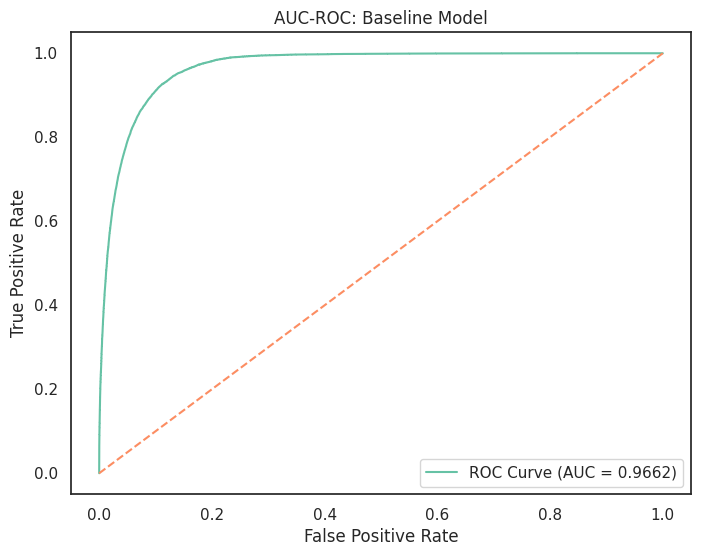

In [17]:
# Plotting the AUC-ROC curve of the baseline model
fpr, tpr, thresholds = roc_curve(y_valid, y_val_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC: Baseline Model")
plt.legend()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

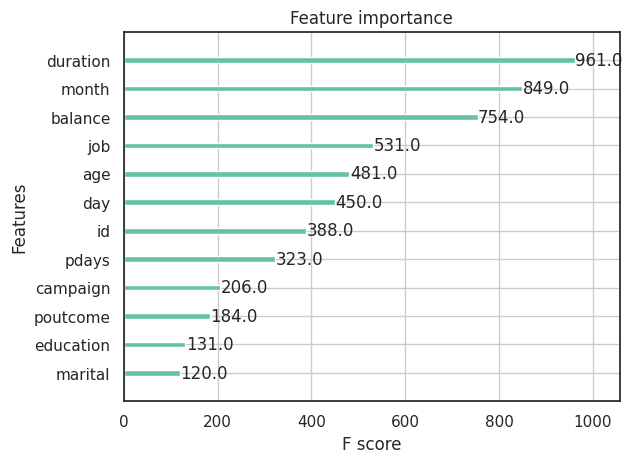

In [18]:
# Plotting feature importance of the baseline model
xgb.plot_importance(baseline_model, max_num_features=12)

### **Summary: Baseline Model**

The XGBoost model above was trained on completely unaltered data (with the exception of correcting object type columns to category type). 

As shown in the AUC-ROC plot, the baseline XGBoost model yielded an AUC score of 0.9662. As mentioned in the About the Project section, this is a solid score, as the AUC value is close to 1.0. 

We can also see the feature importance of the model above, i.e. which features had the greatest impact on the baseline model. Here, we can see that 'duration' was the most important feature, with an F Score of 961.

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#7" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="6"></a>
# **6) Data Preprocessing**

---

In [19]:
# Loading in fresh copies of the Kaggle datasets
df_train = pd.read_csv("/kaggle/input/playground-series-s5e8/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s5e8/test.csv")

In [20]:
# Extracting ids from 'df_test' for later submission
ids = df_test['id']

In [21]:
# Dropping 'id' column from both datasets
df_train.drop(['id'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

In [22]:
# Steps taken if including the original dataset

run = 0

if run == 1:

    # Loading in the original dataset
    df_original = pd.read_csv("/kaggle/input/bank-marketing-dataset-full/bank-full.csv", sep=";")

    # Mapping target variable as 1/0 (int)
    df_original['y'] = df_original['y'].map({'yes': 1, 'no': 0})

    # Combining the 'df_train' and 'df_original' datasets
    df_train = pd.concat([df_train, df_original], axis=0, ignore_index=True)

<a id="top"></a>
<a id="6.1"></a>
## **6.1) Changing Datatypes**

In [23]:
# Declaring numeric and categorical columns

# Numeric (not including id or target variable 'y')
num_cols = ['age', 'balance', 'day', 'duration', 
            'campaign', 'pdays', 'previous']

# Categorical
cat_cols = ['job', 'marital', 'education', 'default',
           'housing', 'loan', 'contact', 'month', 'poutcome']

In [24]:
# Creating function to convert 'object' type columns into 'category'
def convert_object(df):
    for col in cat_cols:
        df[col] = df[col].astype('category')

# Applying 'convert_object' function to both datasets
convert_object(df_train)
convert_object(df_test)

<a id="top"></a>
<a id="6.2"></a>
## **6.2) Outlier Removal**

In [25]:
# Creating function to remove outliers by applying the Inter Quartile method
# Removes outliers from numeric columns
def remove_outliers(df):

    # Initializing deleted row count at 0
    rows_deleted_total = 0

    # Calculating IQR range
    for column in num_cols:
        Q1 = df[column].quantile(0.005)
        Q3 = df[column].quantile(0.995)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Filtering the data, including all data between the lower and upper bounds
        filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        rows_deleted = len(df) - len(filtered_df)
        rows_deleted_total += rows_deleted
        # Printing results of outlier removal
        print(f"{column}: {rows_deleted}")
        # Updating dataframe with removed outliers
        df = filtered_df
    # Printing total number of rows deleted
    print(f"Total rows deleted: {rows_deleted_total}")

# Applying 'remove_outlier' function to datasets
remove_outliers(df_train)
remove_outliers(df_test)

age: 0
balance: 662
day: 0
duration: 30
campaign: 23
pdays: 0
previous: 375
Total rows deleted: 1090
age: 0
balance: 185
day: 0
duration: 9
campaign: 14
pdays: 0
previous: 135
Total rows deleted: 343


<a id="top"></a>
<a id="6.3"></a>
## **6.3) Feature Engineering**

In [26]:
# Creating feature engineering function
def feature_eng(df):    
    df['balance_positive'] = (df['balance'] > 0).astype(int)
    df['has_previous'] = (df['previous'] > 0).astype(int)
    df['duration_long'] = (df['duration'] > 300).astype(int)
    df['campaign_multiple'] = (df['campaign'] > 2).astype(int)
    df['sqrt_age'] = np.sqrt(df['age'])
    # Log features
    df['duration_log']=np.log1p(df['duration'])
    df['campaign_log']=np.log1p(df['campaign'])
    df['pdays_log']=np.log1p(df['pdays']+2)
    df['previous_log']=np.log1p(df['previous']+1)


# Applying 'feature_eng' function to both datasets
feature_eng(df_train)
feature_eng(df_test)

In [27]:
# Verifying changes
df_train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   age                750000 non-null  int64
 1   job                750000 non-null  category
 2   marital            750000 non-null  category
 3   education          750000 non-null  category
 4   default            750000 non-null  category
 5   balance            750000 non-null  int64
 6   housing            750000 non-null  category
 7   loan               750000 non-null  category
 8   contact            750000 non-null  category
 9   day                750000 non-null  int64
 10  month              750000 non-null  category
 11  duration           750000 non-null  int64
 12  campaign           750000 non-null  int64
 13  pdays              750000 non-null  int64
 14  previous           750000 non-null  int64
 15  poutcome           750000 non-null  category
 16  y        

<a id="top"></a>
<a id="6.4"></a>
## **6.4) Preparing for Modeling**

In [28]:
# Creating final versions of each preprocessed dataset
train = df_train.copy()
test = df_test.copy()

### **Data Preprocessing Summary**
- Created fresh copies of data for preprocessing
- Extracted ids from test data for later submission
- Removed 'id' column from both training and testing sets
- Converted all 'object' type columns to 'category'
- Removed outliers outside of IQR range (0.005/0.995)
- Created new variables using feature engineering
- Created copies of preprocessed data, ready for model use

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#8" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="7"></a>
# **7) XGBoost w/ Optuna**

---

<a id="top"></a>
<a id="7.1"></a>
## **7.1) Hyperparameter Tuning**

**Predetermined Parameters**
- 'objective': 'binary:logistic' --> the objective parameter is set to binary:logistic, as this is a binary classification problem
- 'device': xgb_device --> utilizing CUDA to speed up functionality
- 'eval_metric': 'auc' --> the submission of this project is evaluated using the AUC-ROC score
- 'random_state': 42 --> this sets a random state which can be used for reproducing specific results
- 'enable_categorical': True --> this allows us to pass categorical features through the model

**Parameters Needing Optimization**
- 'n_estimators' --> essentially the number of boosting iterations
- 'learning_rate' --> also called eta, the shrinkage rate, helps prevent overfitting, a smaller learning rate may improve performance but may also slow training, default=0.3, range: [0,1] 
- 'colsample_bytree' --> the subsample ratio of columns when constructing each tree, helps speed up training and may improve performance, default=1, range: (0,1]
- 'max_depth' --> this limits the max depth of the tree model, deeper trees can capture more complex patterns but may also overfit, a deeper tree may aggressively consume more memory, default=6, range: [0,inf]
- 'subsample' --> similar to "colsample_bytree" but randomly selects part of the data without resampling, can also be used to speed up training and prevent overfitting, setting to 0.5 would make the model randomly sample half of the training data prior to growing trees, defaul=1, range:(0,1]
- 'min_child_weight' --> minimum sum of instance weight needed in a child, a larger weight will create a more conversative model, default=1, range: [0,inf]
- 'reg_alpha' --> also called alpha, L1 regularization term on weights, increasing this will make the model more conservation, default=0, range: [0,inf]
- 'reg_lambda' --> also called lambda, L2 regularization term on weights, increasing this will make the model more conservation, default=0, range: [0,inf]

In [29]:
# Splitting the data into feature (X) and target (y) arrays
X = train.drop(['y'], axis=1)
y = train['y']

# Splitting the arrays into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, 
                                                      random_state=42, stratify=y)

In [30]:
# Calculating weight for target classes
Class_0 = (train['y'] == 0).sum()
Class_1 = (train['y'] == 1).sum()
scale_pos_weight = Class_1 / Class_0
print(f"scale_pos_weight: {scale_pos_weight:.4f}")

scale_pos_weight: 0.1372


In [31]:
# Creating 'objective' function which will trial different parameter values and combinations
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'device': xgb_device,
        'eval_metric': 'auc',
        'random_state': 42,
        'enable_categorical': True,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        #'scale_pos_weight': scale_pos_weight,
        'n_estimators': 10000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),  
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True) 
    }

    # Fitting XGBoost model with parameters from the trials
    model = xgb.XGBClassifier(**params)
    
    model.fit(X_train, y_train)

    # Making predictions on the validation set
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    score = roc_auc_score(y_valid, y_pred_proba)
    print('ROC-AUC:', score)
    return score

# When set to 1, optuna will create a study to find the optimal parameters for the model
run=0

if run==1:

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)
    print('Best trial:')
    trial = study.best_trial

    print('Value: {}'.format(trial.value))
    print('Params: ')
    for key, value in trial.params.items():
        print(' {}: {}'.format(key, value))

In [32]:
# Recording best parameters from trial #1
best_params = {
    'objective': 'binary:logistic',
    'device': xgb_device,
    'eval_metric': 'auc',
    'random_state': 42,
    'enable_categorical': True,
    'n_estimators': 839, 
    'learning_rate': 0.025193901676668747, 
    'colsample_bytree': 0.4692203584552837, 
    'max_depth': 12, 
    'subsample': 0.7737770422287007, 
    'min_child_weight': 7, 
    'reg_alpha': 0.008655641788467871, 
    'reg_lambda': 0.09225529592581996
}

In [33]:
# Recording best parameters from trial #2
best_params_2 = {
    'objective': 'binary:logistic',
    'device': xgb_device,
    'eval_metric': 'auc',
    'random_state': 42,
    'enable_categorical': True,
    'n_estimators': 10000, 
    'learning_rate': 0.025193901676668747, 
    'colsample_bytree': 0.4692203584552837, 
    'max_depth': 12, 
    'subsample': 0.7737770422287007, 
    'min_child_weight': 7, 
    'reg_alpha': 0.008655641788467871, 
    'reg_lambda': 0.09225529592581996
}

In [34]:
# Fitting the model with the best parameters!
final_model = xgb.XGBClassifier(**best_params_2)

<a id="top"></a>
<a id="7.2"></a>
## **7.2) Model Evaluation**

In [35]:
# Fitting the model with the training data
final_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=40, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4692203584552837, device='cuda',
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='auc', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025193901676668747,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [36]:
# Making predictions on the validation set
y_val_pred_proba = final_model.predict_proba(X_valid)[:, 1]

In [37]:
# Evaluating the performance of the final model
auc_score = roc_auc_score(y_valid, y_val_pred_proba)
print(f'Validation ROC-AUC Score: {auc_score:.4f}')

Validation ROC-AUC Score: 0.9685


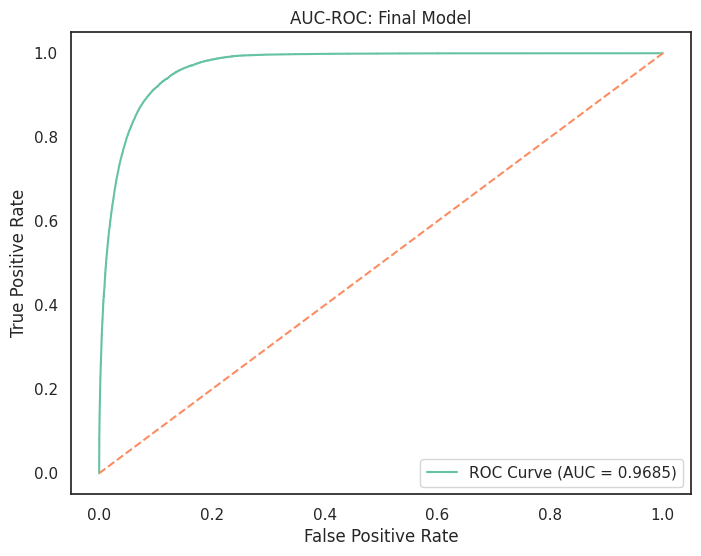

In [38]:
# Plotting the AUC-ROC curve of the final model
fpr, tpr, thresholds = roc_curve(y_valid, y_val_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC: Final Model")
plt.legend()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

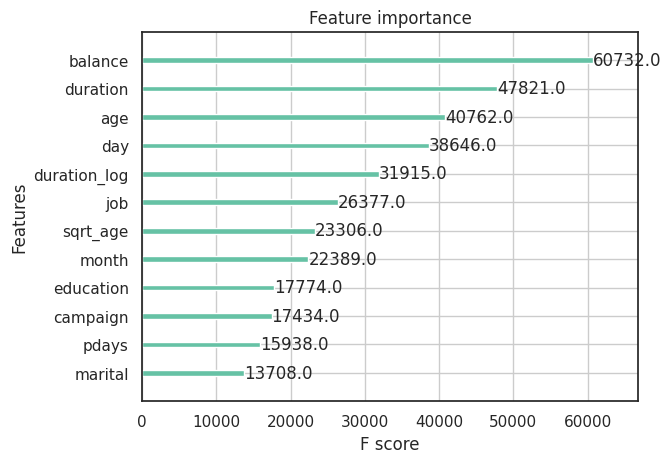

In [39]:
# Plotting feature importance of the final model
xgb.plot_importance(final_model, max_num_features=12)

### **Summary: Final Model**

The final model yielded an AUC score of 0.9685. 

The most impactful feature on the model was 'balance', with an F Score of 60732. The second most impactful feature was 'duration'.  

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#c" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="8"></a>
# **8) Submission**

---

In [40]:
# Making final predictions on the test data
preds = final_model.predict_proba(test)[:,1]

In [41]:
# Creating 'submission' dataframe to store predictions with ids
submission = pd.DataFrame({'id': ids, 'y': preds})
submission

,id,y
0,750000,0.001298
1,750001,0.102466
2,750002,0.000277
3,750003,0.000088
4,750004,0.012084
...,...,...
249995,999995,0.000084
249996,999996,0.112993
249997,999997,0.729409
249998,999998,0.000441


In [42]:
# Creating .csv file for submissions and scoring
run = 1

if run == 1:
    submission.to_csv('submission.csv', index=False)

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a id="c"></a>
# **Conclusion**

---

### **Final Model Performance: XGBoost**

The final XGBoost model (tuned with Optuna and using preprocessed data) yielded an AUC score of **0.9685**. This represents a slight increase from the baseline model, which yielded an AUC score of 0.9662. 

The current public Kaggle score for this model is **0.96929**.

### **Considerations**

This project represents a first draft tackle of this binary classification task. Below are several potential changes that could be deployed to improve the AUC score:

Preprocessing:
- Adjusting IQR to remove more outliers
- Binning of numeric features
- Creating more interaction features
- One-hot encoding categorical features

Model:
- Trying different suggested parameter values for Optuna trials
- Ensembling results with other models

### **Thank you!**

Thank you again for taking the time to view my project. Again, please feel free to leave a comment if you have any questions or suggestions for this work.

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a id="r"></a>
# **References**

---

- Kaggle Competition: https://www.kaggle.com/competitions/playground-series-s5e8/overview
- Term Deposit Definition (Investopedia): https://www.investopedia.com/terms/t/termdeposit.asp
- XGBoost: https://xgboost.ai/
- Optuna: https://optuna.org/
- ROC: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
- RAPIDS: https://rapids.ai/cudf-pandas/